# Requirements

In [1]:
# For machine learning
import torch
import torch.nn as nn

# For data processing
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

# For data pre-processing
import glob
import pandas as pd
import numpy as np
from torchvision.io import decode_image
from torchvision import transforms
from sklearn.preprocessing import StandardScaler

# For representation
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cuda device


#### Global variables

In [ ]:
DATA_DIR = '/kaggle/input/weather/data'  # The folder name of our data

TYPES = { # Data types of all our attributes inside csv files
    'LAMBX' : np.int32, 
    'LAMBY' : np.int32, 
    'DATE' : np.int32, 
    'PRENEI' : np.float32, 
    'PRELIQ' : np.float32, 
    'T' : np.float32, 
    'FF' : np.float32, 
    'Q' : np.float32, 
    'DLI' : np.float32,
    'SSI' : np.float32, 
    'HU' : np.float32, 
    'EVAP' : np.float32, 
    'ETP' : np.float32, 
    'PE' : np.float32, 
    'SWI' : np.float32, 
    'SSWI_10J' : np.float32, 
    'DRAINC' : np.float32, 
    'RUNC' : np.float32,
    'RESR_NEIGE' : np.float32, 
    'RESR_NEIGE6' : np.float32, 
    'HTEURNEIGE' : np.float32, 
    'HTEURNEIGE6' : np.float32, 
    'HTEURNEIGEX' : np.float32,
    'SNOW_FRAC' : np.float32, 
    'ECOULEMENT' : np.float32, 
    'WG_RACINE' : np.float32, 
    'WGI_RACINE' : np.float32, 
    'TINF_H' : np.float32,
    'TSUP_H' : np.float32
}

#### Pre-Processing

In [ ]:
# !!! __init__ goes up to 28Gb of RAM !!!

class CSVFolderDataset(Dataset):
    def __init__(self):
        # Our 4 dataset
        all_files = glob.glob(DATA_DIR + "/*.csv")

        # Concatening our datasets
        self.data = pd.concat((pd.read_csv(f, sep = ';', dtype = TYPES) for f in all_files), ignore_index=True)

        # Managing date
        self.data['DATE'] = pd.to_datetime(self.data['DATE'], format='%Y%m%d') # Use to have correct format of date, will be use to sort
        days = self.data['DATE'].dt.dayofyear
        self.data['day_sin'] = np.sin(2 * np.pi * days / 366.0)
        self.data['day_cos'] = np.cos(2 * np.pi * days / 366.0)

        # Managing locations
        self.data['LOCATION'] = self.data['LAMBX'].astype(str) + '_' + self.data['LAMBY'].astype(str) # Necessary to create a unique ID for positions
        self.data = self.data.astype({'LAMBX' : np.float32, 'LAMBY' : np.float32, 'day_sin' : np.float32, 'day_cos' : np.float32}) # All features need to be in float32

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # label
        label = self.data.loc[idx, 'T'] # Get only 'T' column

        # features
        features = self.data.drop(columns = 'T').iloc[idx] # Get all except 'T' column
        
        return features, label

In [6]:
dataset = CSVFolderDataset()

#### Affichage de quelques données

In [7]:
selected_locations = ['760_23930', '11960_17450']

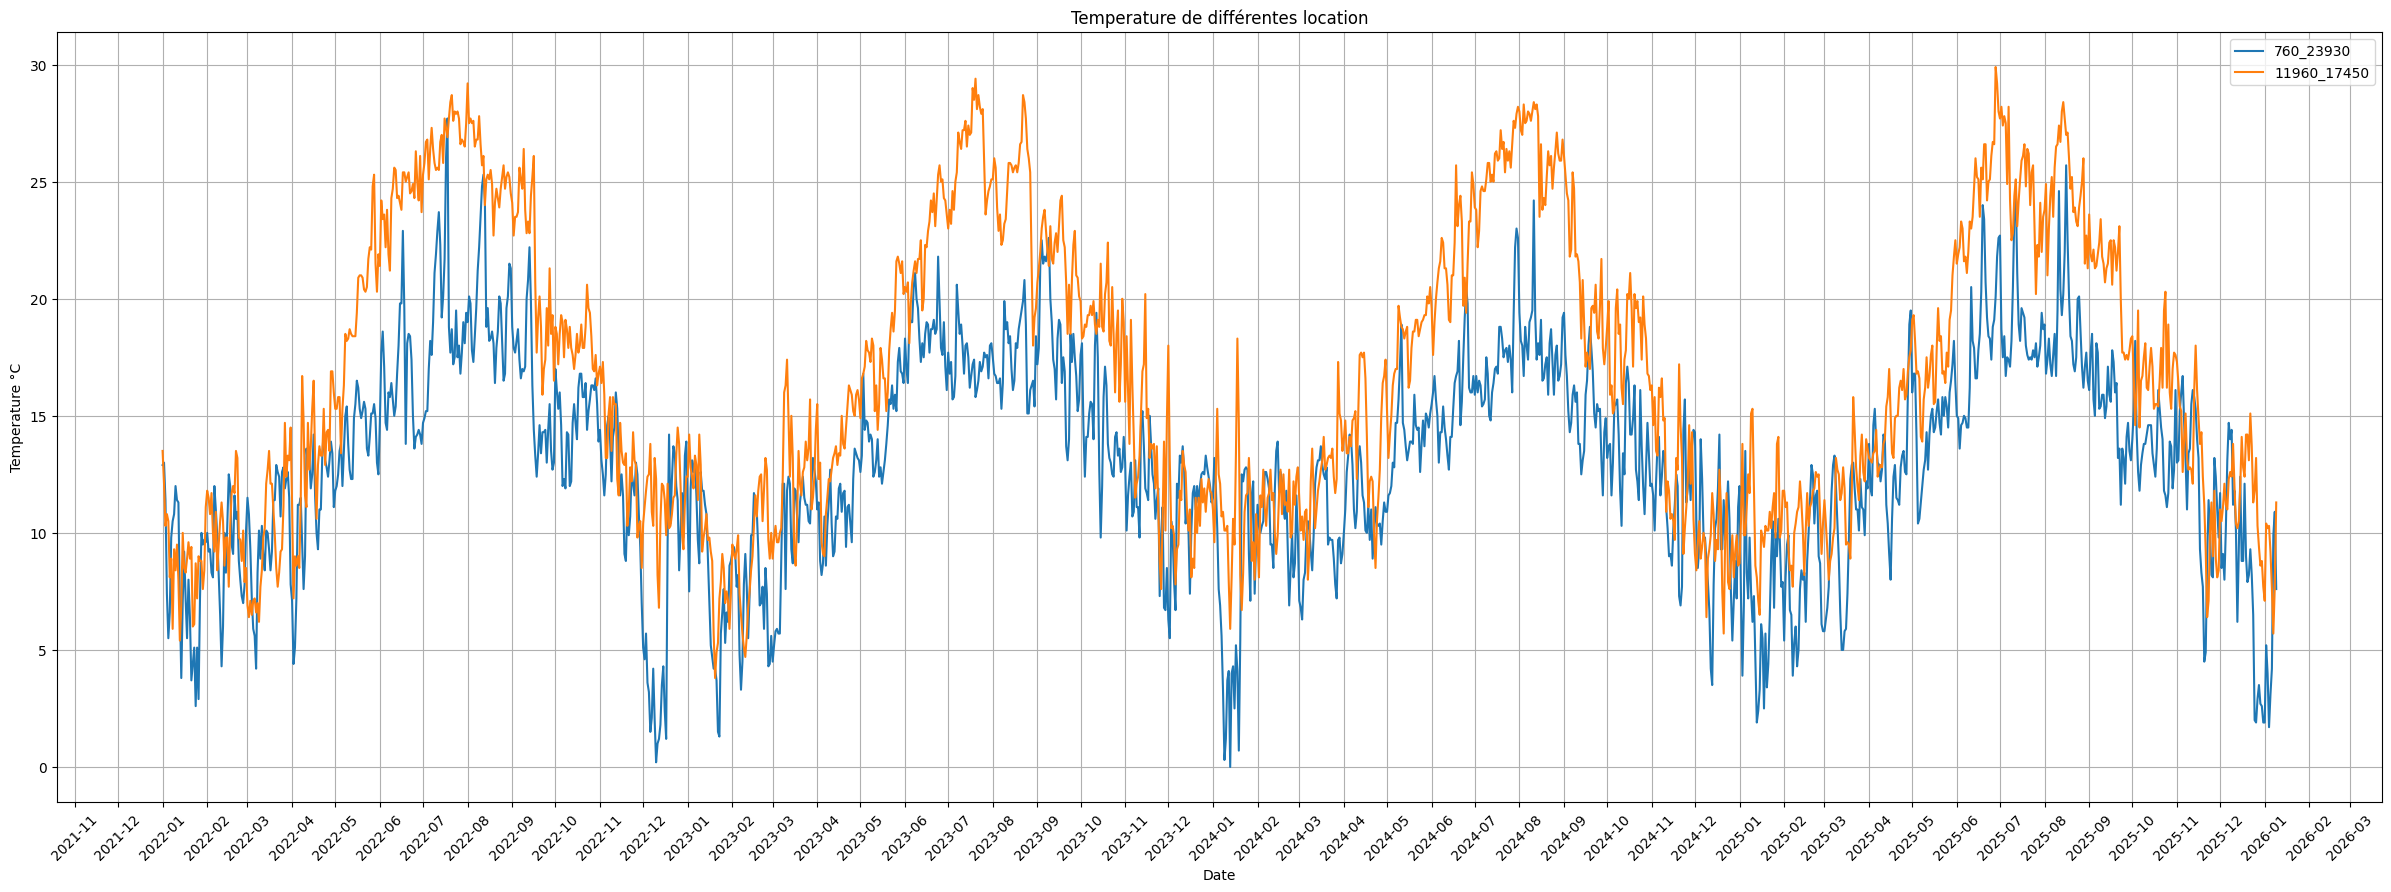

In [8]:
fig, ax = plt.subplots(figsize=(30, 10))

for loc in selected_locations:
    data = dataset.data[dataset.data['LOCATION'] == loc]
    ax.plot(data['DATE'], data['T'], label = loc)

ax.set_title('Temperature de différentes location')
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(mdates.MonthLocator()) # To add all monthes instead of just having years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # To apply a better format
plt.xticks(rotation=45)
ax.set_ylabel('Temperature °C')
ax.legend(loc = 'upper right')
ax.grid()

plt.show()

In [9]:
dataset.data

,LAMBX,LAMBY,DATE,PRENEI,PRELIQ,T,FF,Q,DLI,SSI,...,HTEURNEIGEX,SNOW_FRAC,ECOULEMENT,WG_RACINE,WGI_RACINE,TINF_H,TSUP_H,day_sin,day_cos,LOCATION
0,600.0,24010.0,2022-01-01,0.0,2.8,14.7,7.4,8.739,3111.800049,117.199997,...,0.0,0.0,0.0,0.289,0.0,14.1,15.6,0.017166,0.999853,600_24010
1,600.0,24010.0,2022-01-02,0.0,0.3,12.8,8.2,8.088,3174.399902,129.399994,...,0.0,0.0,0.0,0.289,0.0,12.2,13.3,0.034328,0.999411,600_24010
2,600.0,24010.0,2022-01-03,0.0,13.3,11.2,4.8,7.767,3145.000000,74.599998,...,0.0,0.0,0.0,0.289,0.0,9.8,12.4,0.051479,0.998674,600_24010
3,600.0,24010.0,2022-01-04,0.0,2.7,8.1,8.0,5.346,2737.000000,292.899994,...,0.0,0.0,0.0,0.294,0.0,6.0,9.7,0.068615,0.997643,600_24010
4,600.0,24010.0,2022-01-05,0.0,0.0,6.4,3.6,4.245,2444.500000,241.500000,...,0.0,0.0,0.0,0.294,0.0,4.9,8.0,0.085731,0.996318,600_24010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14541235,11960.0,17450.0,2026-01-05,0.0,4.9,9.2,3.9,6.057,2747.000000,139.699997,...,0.0,0.0,0.0,0.324,0.0,8.3,10.6,0.085731,0.996318,11960_17450
14541236,11960.0,17450.0,2026-01-06,0.0,4.6,7.6,3.6,5.480,2930.300049,217.000000,...,0.0,0.0,0.0,0.326,0.0,6.7,10.3,0.102821,0.994700,11960_17450
14541237,11960.0,17450.0,2026-01-07,0.0,6.8,5.7,3.7,4.218,2533.500000,339.200012,...,0.0,0.0,0.0,0.327,0.0,4.5,8.4,0.119881,0.992788,11960_17450
14541238,11960.0,17450.0,2026-01-08,0.0,0.1,7.7,1.8,4.500,2388.100098,448.799988,...,0.0,0.0,0.0,0.329,0.0,3.3,10.8,0.136906,0.990584,11960_17450


In [10]:
dataset.data['LOCATION'].unique()

array(['600_24010', '760_23610', '760_23930', ..., '11960_17210',
       '11960_17290', '11960_17450'], dtype=object)

In [11]:
dataset.data.dtypes

LAMBX                 float32
LAMBY                 float32
DATE           datetime64[ns]
PRENEI                float32
PRELIQ                float32
T                     float32
FF                    float32
Q                     float32
DLI                   float32
SSI                   float32
HU                    float32
EVAP                  float32
ETP                   float32
PE                    float32
SWI                   float32
SSWI_10J              float32
DRAINC                float32
RUNC                  float32
RESR_NEIGE            float32
RESR_NEIGE6           float32
HTEURNEIGE            float32
HTEURNEIGE6           float32
HTEURNEIGEX           float32
SNOW_FRAC             float32
ECOULEMENT            float32
WG_RACINE             float32
WGI_RACINE            float32
TINF_H                float32
TSUP_H                float32
day_sin               float32
day_cos               float32
LOCATION               object
dtype: object

In [12]:
dataset.data.loc[dataset.data['LOCATION'] == '600_24010']['T']

0           14.7
1           12.8
2           11.2
3            8.1
4            6.4
            ... 
14452216     3.6
14452217     4.2
14452218     9.5
14452219    10.0
14452220     7.8
Name: T, Length: 1470, dtype: float32

In [13]:
dataset.data.columns

Index(['LAMBX', 'LAMBY', 'DATE', 'PRENEI', 'PRELIQ', 'T', 'FF', 'Q', 'DLI',
       'SSI', 'HU', 'EVAP', 'ETP', 'PE', 'SWI', 'SSWI_10J', 'DRAINC', 'RUNC',
       'RESR_NEIGE', 'RESR_NEIGE6', 'HTEURNEIGE', 'HTEURNEIGE6', 'HTEURNEIGEX',
       'SNOW_FRAC', 'ECOULEMENT', 'WG_RACINE', 'WGI_RACINE', 'TINF_H',
       'TSUP_H', 'day_sin', 'day_cos', 'LOCATION'],
      dtype='object')

In [14]:
features = [
   'day_sin', 'day_cos', 'LAMBX', 'LAMBY', 'PRENEI', 'PRELIQ', 'FF', 'Q', 'DLI', 'SSI', 'HU', 'EVAP',
   'ETP', 'PE', 'SWI', 'SSWI_10J', 'DRAINC', 'RUNC', 'RESR_NEIGE',
   'RESR_NEIGE6', 'HTEURNEIGE', 'HTEURNEIGE6', 'HTEURNEIGEX', 'SNOW_FRAC',
   'ECOULEMENT', 'WG_RACINE', 'WGI_RACINE', 'TINF_H', 'TSUP_H',
    ]

features

['day_sin',
 'day_cos',
 'LAMBX',
 'LAMBY',
 'PRENEI',
 'PRELIQ',
 'FF',
 'Q',
 'DLI',
 'SSI',
 'HU',
 'EVAP',
 'ETP',
 'PE',
 'SWI',
 'SSWI_10J',
 'DRAINC',
 'RUNC',
 'RESR_NEIGE',
 'RESR_NEIGE6',
 'HTEURNEIGE',
 'HTEURNEIGE6',
 'HTEURNEIGEX',
 'SNOW_FRAC',
 'ECOULEMENT',
 'WG_RACINE',
 'WGI_RACINE',
 'TINF_H',
 'TSUP_H']

In [15]:
dataset[0]

(LAMBX                        600.0
 LAMBY                      24010.0
 DATE           2022-01-01 00:00:00
 PRENEI                         0.0
 PRELIQ                         2.8
 FF                             7.4
 Q                            8.739
 DLI                    3111.800049
 SSI                     117.199997
 HU                            85.0
 EVAP                           1.5
 ETP                            1.4
 PE                             1.3
 SWI                          0.766
 SSWI_10J                    -0.884
 DRAINC                         0.3
 RUNC                           0.2
 RESR_NEIGE                     0.0
 RESR_NEIGE6                    0.0
 HTEURNEIGE                     0.0
 HTEURNEIGE6                    0.0
 HTEURNEIGEX                    0.0
 SNOW_FRAC                      0.0
 ECOULEMENT                     0.0
 WG_RACINE                    0.289
 WGI_RACINE                     0.0
 TINF_H                        14.1
 TSUP_H                     

#### Normalization

In [16]:
scaler = StandardScaler()

# Normalize
normalize_data = dataset.data[features + ['T']].values
normalize_data = scaler.fit_transform(normalize_data)

# Create the Dataframe back
normalize_data = pd.DataFrame(normalize_data, columns=features + ['T'])
normalize_data['LOCATION'] = dataset.data['LOCATION']
normalize_data['DATE'] = dataset.data['DATE']

dataset.data = normalize_data

#### Transformation des données journalières en séquences (de 7 jours)

In [17]:
# Prepare Data for RNN Input
def create_sequences_multivariate(data : pd.DataFrame, seq_length : int, feature_cols : list, target_col : str):
    """
    For each location, replace the current T value and features with a sequence of 7 previous ones
        Convert 1 T of a day -> 7 T of the previous 7 days to this date (thanks to sort 'DATE')
    """

    data = data.sort_values(['DATE', 'LOCATION'])
    
    sequences = []
    targets = []
    
    # Group by locations
    for location, group in data.groupby('LOCATION'):
        #group = group.sort_values('DATE')
        
        # Extract values
        feature_data = group[feature_cols].values
        target_data = group[target_col].values
        
        # Create sliding windows
        for i in range(len(group) - seq_length):
            seq = feature_data[i:i+seq_length]
            target = target_data[i+seq_length]
            
            sequences.append(seq)
            targets.append(target)

    sequences = np.array(sequences)
    targets = np.array(targets)
    print(sequences.shape, targets.shape)
    return sequences, targets 

In [18]:
X_array, Y_array = create_sequences_multivariate(dataset.data, 7, features, 'T')

(14471996, 7, 29) (14471996,)


In [19]:
X_tensor = torch.FloatTensor(X_array)
Y_tensor = torch.FloatTensor(Y_array).view(-1, 1) # Convert to Tensor (float32 by default)

In [ ]:
TRAIN_SIZE = int(len(X_tensor) * 0.9) # Repartition between training and testing

X_train, Y_train = X_tensor[:TRAIN_SIZE], Y_tensor[:TRAIN_SIZE]
X_test, Y_test = X_tensor[TRAIN_SIZE:], Y_tensor[TRAIN_SIZE:]

# Create DataLoaders
BATCH_SIZE = 1024

train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [21]:
# https://www.codegenes.net/blog/lastm-pytorch/
# https://www.geeksforgeeks.org/deep-learning/long-short-term-memory-networks-using-pytorch/
# The WeatherLSTM simple architecture come from these links

class WeatherLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(WeatherLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM Layer
        # batch_first=True means input shape is (Batch, Seq, Features)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully Connected Layer to predict final value
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Pass through Linear layer
        out = self.fc(out[:, -1, :]) # Take last time step
        
        return out

In [22]:
INPUT_SIZE = len(features) # Should be around 25
HIDDEN_SIZE = 64
NUM_LAYERS = 1
OUTPUT_SIZE = 1 # We're forecasting only 'T'

In [23]:
model = WeatherLSTM(input_size = INPUT_SIZE, hidden_size = HIDDEN_SIZE, num_layers = NUM_LAYERS, output_size = OUTPUT_SIZE)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [24]:
def train(dataloader, model):
    size = len(dataloader.dataset)
    
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Reset gradients
        optimizer.zero_grad()
        
        # Forward
        pred = model(X)

        # Compute loss
        loss = criterion(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        loss.item()

        if batch % int(size / 10) == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [25]:
def test(dataloader, model):
    num_batches = len(dataloader)
    model.eval()
    
    test_loss = 0
    predictions = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            # Make prediction
            pred = model(X)
            
            # Calculate loss (MSE)
            test_loss += criterion(pred, y).item()
            
            # Store results for plotting later
            predictions.append(pred.cpu().numpy())

    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    
    # Flatten lists to simple arrays
    predictions = np.concatenate(predictions)

    num_features = len(features) + 1 
    dummy_matrix = np.zeros((len(predictions), num_features))
    
    # Put predictions into the column corresponding to 'T' (usually the last one)
    dummy_matrix[:, 5] = predictions.flatten()
    
    # Inverse transform
    rescaled_matrix = scaler.inverse_transform(dummy_matrix)
    
    # Extract just the temperature column
    final_predictions = rescaled_matrix[:, 5]
    
    return final_predictions

In [ ]:
NUM_EPOCHS = 1
preds = []

for epoch in range(NUM_EPOCHS):
    print(f"Epoch n° {epoch} ------------")
    
    train(train_loader, model)
    preds.append(test(test_loader, model))

In [38]:
def get_last_sequences_per_location(df, seq_length, feature_cols, target_col, scaler):
    """
    Extracts the last 'seq_length' rows for every unique location.
    Returns: Tensor of shape [Num_Locations, Seq_Len, Features], List of Location IDs
    """
    last_seqs = []
    loc_ids = []
    
    df = df.sort_values(['LOCATION', 'DATE'])
    
    for loc, group in df.groupby('LOCATION'):
        if len(group) < seq_length:
            continue

        raw_values = group[feature_cols + [target_col]].tail(seq_length).values
        scaled_values = scaler.transform(raw_values)
        
        all_cols = feature_cols + [target_col]
        
        feature_indices = [all_cols.index(f) for f in feature_cols]
        
        final_seq = scaled_values[:, feature_indices]
        
        last_seqs.append(final_seq)
        loc_ids.append(loc)

    batch_tensor = torch.FloatTensor(np.array(last_seqs))
    
    return batch_tensor, loc_ids

last_sequences_tensor, location_ids = get_last_sequences_per_location(dataset.data, 7, features, 'T', scaler)

print(f"Ready to predict for {len(location_ids)} locations.")
print(f"Input Shape: {last_sequences_tensor.shape}")

Ready to predict for 9892 locations.
Input Shape: torch.Size([9892, 7, 29])


In [39]:
def predict_future_all_locs(model, last_sequences, future_steps, scaler, feature_cols):
    """
    Predicts future steps for ALL locations simultaneously.
    """
    model.eval()
    
    current_seq = last_sequences.clone().detach().to(device)
    
    all_preds = []
    
    with torch.no_grad():
        for _ in range(future_steps):
            pred = model(current_seq)
            
            all_preds.append(pred.cpu().numpy())
            
            new_row = current_seq[:, -1, :].clone()
            
            if 'T' in feature_cols:
                t_index = feature_cols.index('T')
                new_row[:, t_index] = pred.squeeze()
            
            new_row = new_row.unsqueeze(1)
            current_seq = torch.cat((current_seq[:, 1:, :], new_row), dim=1)

    all_preds = np.array(all_preds).squeeze()
    
    flat_preds = all_preds.flatten()
    
    dummy = np.zeros((len(flat_preds), scaler.n_features_in_))
    
    dummy[:, 5] = flat_preds
    
    unscaled = scaler.inverse_transform(dummy)[:, 5]
    
    final_forecast = unscaled.reshape(future_steps, len(location_ids)).T
    
    last_date = dataset.data['DATE'].max()
    future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, future_steps + 1)]
    
    return final_forecast, future_dates

FUTURE_STEPS = 30
forecast_values, forecast_dates = predict_future_all_locs(
    model, 
    last_sequences_tensor, 
    FUTURE_STEPS, 
    scaler, 
    features
)

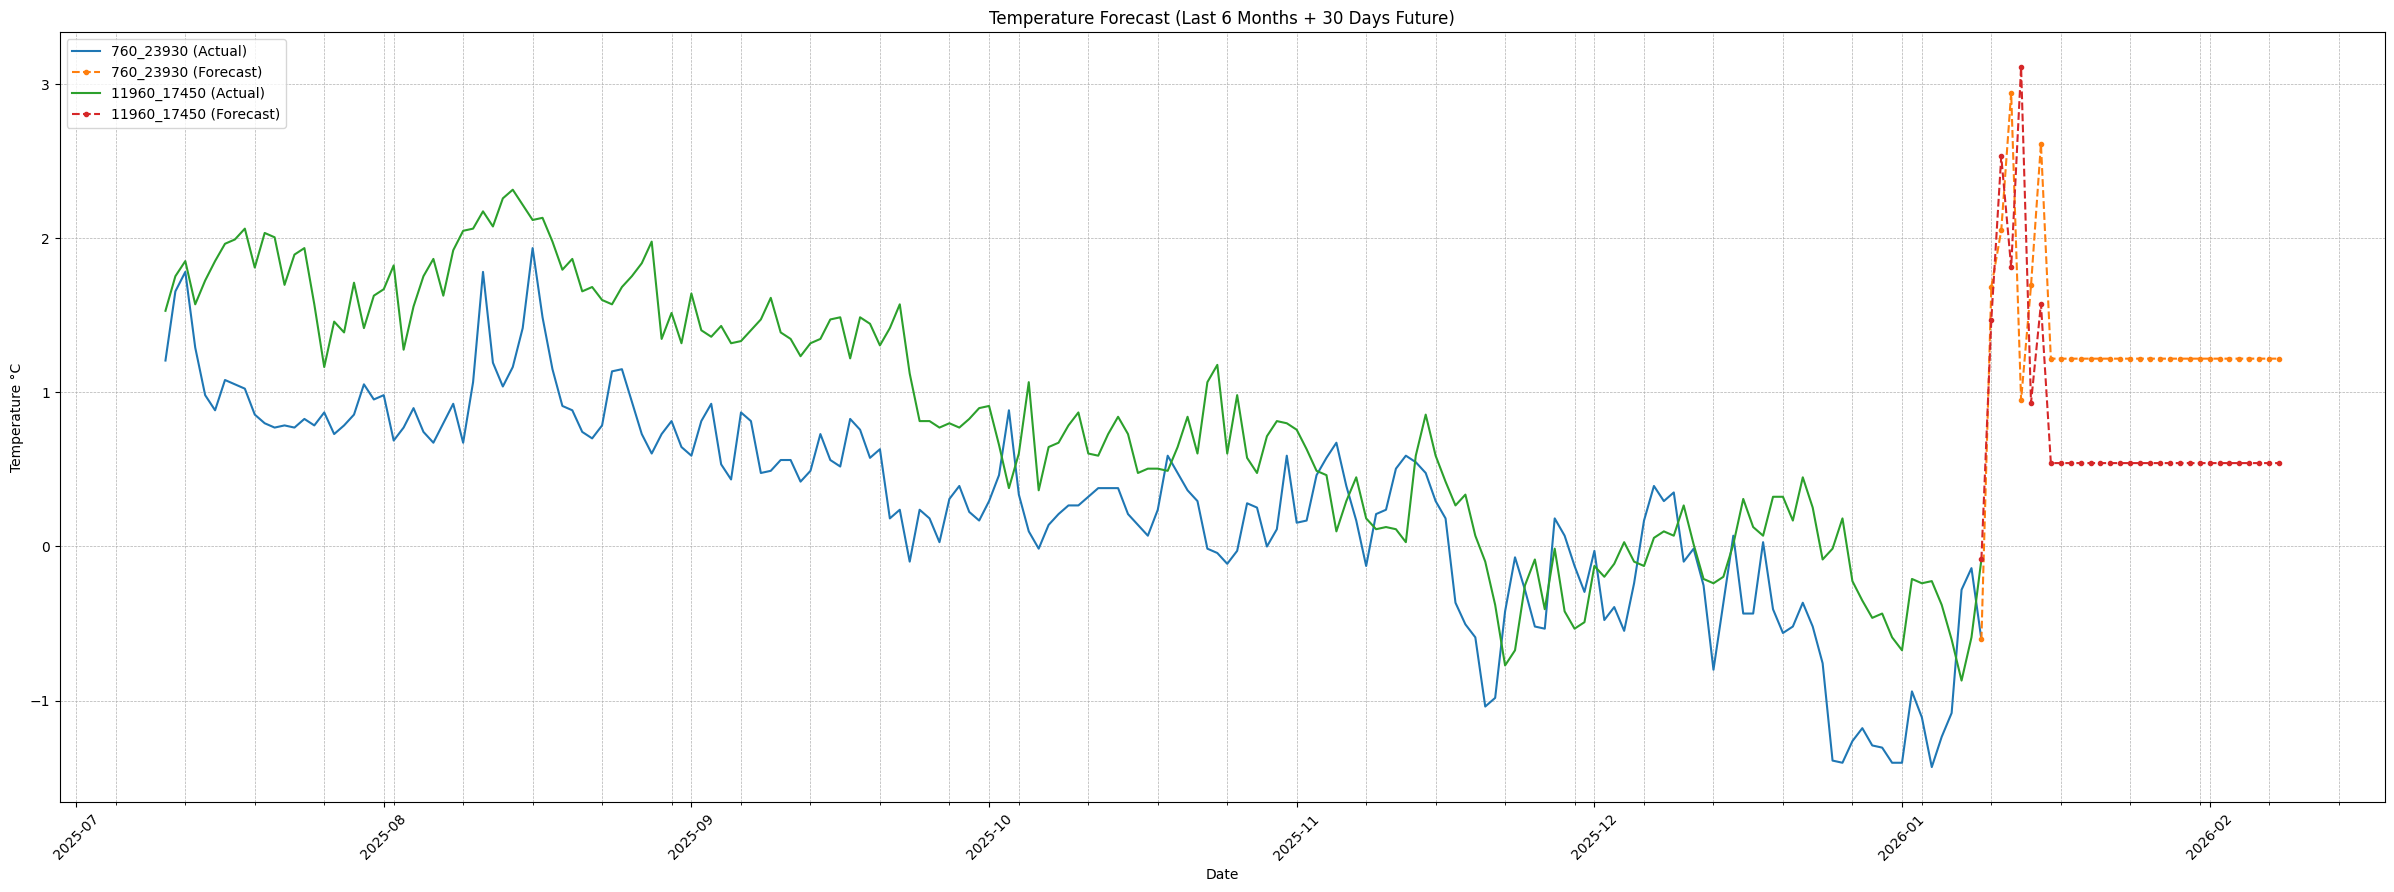

In [40]:
pred_df = pd.DataFrame(forecast_values, index=location_ids, columns=forecast_dates)

fig, ax = plt.subplots(figsize=(30, 10))

max_date = dataset.data['DATE'].max()
cutoff_date = max_date - pd.DateOffset(months=6)

for loc in selected_locations:
    history = dataset.data[dataset.data['LOCATION'] == loc]
    
    history = history[history['DATE'] > cutoff_date]
    
    ax.plot(history['DATE'], history['T'], label=f"{loc} (Actual)")
    
    if loc in pred_df.index:
        loc_preds = pred_df.loc[loc]
        
        last_actual_date = history['DATE'].iloc[-1]
        last_actual_val = history['T'].iloc[-1]
        
        plot_dates = [last_actual_date] + list(forecast_dates)
        plot_vals = [last_actual_val] + list(loc_preds.values)
        
        ax.plot(plot_dates, plot_vals, linestyle='--', marker='.', label=f"{loc} (Forecast)")

ax.set_title(f'Temperature Forecast (Last 6 Months + {FUTURE_STEPS} Days Future)')
ax.set_xlabel('Date')

# Date Formatting
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7)) # Add weekly ticks for detail

plt.xticks(rotation=45)
ax.set_ylabel('Temperature °C')
ax.legend(loc='upper left')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

On peut voir que les prédictions sont très mauvaises à moyen et longs terme. Cela est dû au fait que la prédiction initiale effectue au prédiction du jour + 1 (de sa température) et les prédictions futures se basent sur cette unique prédiction de température pour essayer de prédire les jours suivants. Or le modèle n'est pas fait pour ça étant donné que dans ce cas il ne possède pas assez de features pour faire une bonne prédiction (mais seulement la température). Le modèle a été entrainé sur de nombreux attributs et on remarque bien, avec le MSE, que pour les prédictions à très courts termes (ex 1 jour), les résultats sont excellents avec un MSE inférieur à 10^-1.